## 学習に用いる事項


In [178]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os

### 損失関数

ニューラルネットワークの出力が $\bm{y}$ 、教師データ（one-hot 表現）が $\bm{t}$ のとき、

**２乗和誤差**: $ E = \frac{1}{2} \Sigma_k (y_k - t_k)^2 $

**交差エントロピー誤差**: $ E = - \Sigma_k (t_k \log y_k) $

認識精度そのものは、多くの場所で微分不可能なので、学習のための指標としては利用できない

### ミニバッチ学習

100 枚など、無作為に選んだミニバッチに対して損失関数を計算する

$$
E = \frac{1}{N} \Sigma_n E_n
$$


### 数値微分

誤差を減らすため、 $f(x+h)$ と $f(x-h)$ の差を利用する方法（中心差分）が用いられる。

$$
f'(x) = \frac{f(x+h)-f(x-h)}{2h}
$$

$h = 10^{-4}$ 程度で良い結果が得られることが知られている。


In [179]:
def diff(f, x):
    h = 1e-4
    return (f(x + h) - f(x - h)) / (2 * h)

**例：** $f(x) = 0.01 x^2 + 0.1 x$ の数値微分


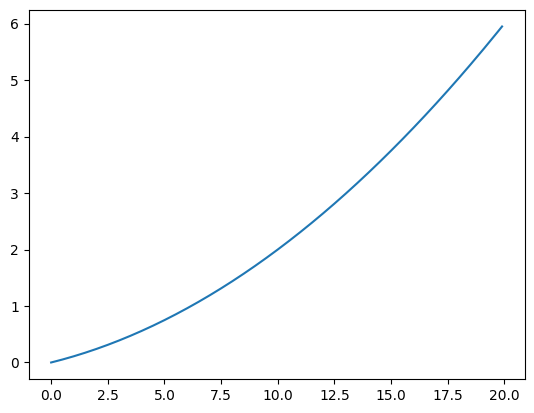

x=5における微分：0.1999999999990898
x=10における微分：0.2999999999986347


In [180]:
# f(x)の定義
def f(x: float):
    return 0.01 * x**2 + 0.1 * x


# 0から20まで、0.1刻みのxを用意
x = np.arange(0, 20, 0.1)

# f(x)の結果を格納した配列
y = f(x)

# グラフを表示
plt.plot(x, y)
plt.show()

# x=5, 10における微分を計算
print(f"x=5における微分：{diff(f, 5)}")
print(f"x=10における微分：{diff(f, 10)}")

### 勾配

$f(x_0, x_1) = x_0^2 + x_1^2$
を例に計算してみる


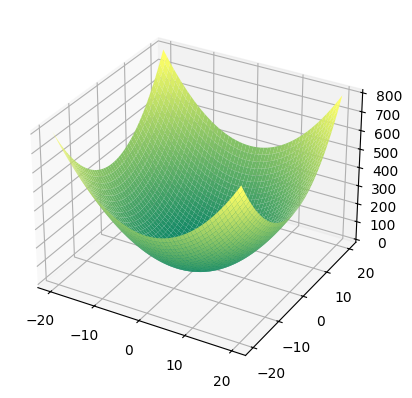

In [181]:
# fの実装
def f(x: np.ndarray):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)

# fのグラフを描画してみる
x0_range = np.linspace(-20, 20, 1000)
x1_range = np.linspace(-20, 20, 1000)
x0, x1 = np.meshgrid(x0_range, x1_range)
f_mesh = x0**2 + x1**2  # fの実装（Meshgridで）
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(x0, x1, f_mesh, cmap="summer")  # type: ignore

$\mathrm{grad} f = \left( \frac{\partial f}{\partial x_0}, \frac{\partial f}{\partial x_1} \right)$


In [182]:
# 勾配を求める関数を実装
def grad(f, x: np.ndarray):
    h = 1e-4
    grad = np.zeros_like(x)

    for idx in range(x.size):

        # 現在の x の値をコピー
        tmp = x[idx]

        # x_i + h のときの値を計算
        x[idx] = tmp + h
        fxh1 = f(x)

        # x_i - h のときの値を計算
        x[idx] = tmp - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2 * h)

        # x_iの値を元に戻す
        x[idx] = tmp
    
    return grad

# 勾配を求める関数をテスト
print(grad(f, np.array([3.0, 4.0])))

[6. 8.]


### 勾配法

学習率 $\eta$ として、 $x_0 = x_0 - \eta \frac{\partial f}{\partial x_0}$, $x_1 = x_1 - \eta \frac{\partial f}{\partial x_1}$ とする

In [183]:
# 勾配法を実装
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    for i in range(step_num):
        x -= lr * grad(f, x)
    return x

# η = 0.1 で実行（良いパターン）
print(f'η = 0.1: {gradient_descent(f, init_x=np.array([-3.0, 4.0]), lr=0.1, step_num=100)}')

# η = 0.001 で実行（ほとんど更新されない）
print(f'η = 0.001: {gradient_descent(f, init_x=np.array([-3.0, 4.0]), lr=0.001, step_num=100)}')

# η = 10 で実行（値が発散）
print(f'η = 10: {gradient_descent(f, init_x=np.array([-3.0, 4.0]), lr=10, step_num=100)}')

η = 0.1: [-6.11110793e-10  8.14814391e-10]
η = 0.001: [-2.45570041  3.27426722]
η = 10: [-2.58983747e+13 -1.29524862e+12]


### ニューラルネットワークの勾配

ネットワーク $W = \begin{bmatrix} w_{11} & w_{12} & w_{13} \\ w_{21} & w_{22} & w_{23} \end{bmatrix}$ によって損失関数 $L$ が決定されるとき、勾配は $ \frac{\partial L}{\partial W} = \begin{bmatrix} \frac{\partial L}{\partial w_{11}} & \frac{\partial L}{\partial w_{12}} & \frac{\partial L}{\partial w_{13}} \\ \frac{\partial L}{\partial w_{21}} & \frac{\partial L}{\partial w_{22}} & \frac{\partial L}{\partial w_{23}} \end{bmatrix} $

In [184]:
sys.path.append("../deep-learning-from-scratch-master")
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:

    def __init__(self):
        # 重みをガウス分布で初期化
        self.W = np.random.randn(2, 3)
    
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        return cross_entropy_error(y, t)

In [185]:
net = simpleNet()
print(net.W)

x = np.array([0.6, 0.9])
p = net.predict(x)
print(p) # ネットワークの出力
print(np.argmax(p)) # 予測結果

t = np.array([0, 0, 1])
print(net.loss(x, t)) # 損失関数

[[ 1.58795856 -0.83922575 -0.38178746]
 [-1.34621891 -1.23430867 -0.2601643 ]]
[-0.25882188 -1.61441325 -0.46322034]
0
0.93336238403622


In [186]:
def f(W):
    return net.loss(x, t)

dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.28944498  0.07461741 -0.36406239]
 [ 0.43416747  0.11192611 -0.54609358]]
